# Extreme Value Statistics of the halo and stellar mass distributions

In this notebook we show how to create confidence intervals in the stellar/halo mass--redshift plane for the most massive object predicted by extreme value statistics (EVS) of the halo mass function (HMF), combined with realistic models of the stellar and baryon fraction. In these examples we use pre-calculated arrays assuming the same fiducial cosmology and halo mass function parametrisation used in Lovell et al. 2022; detais on how to re-calculate these arrays for _e.g._ arbitrary cosmologies is described at the bottom of this notebook.

This notebook requires the following modules to be installed: `numpy`, `h5py`, `astropy` and `matplotlib`.

### An example

You first need to install the `evstats` module, which should be as simple as cloning this repository and running

`python setup.py install`

in the module parent directory.

We can then import our required modules.

In [584]:
import numpy as np
import h5py, os, sys
import matplotlib.pyplot as plt
import astropy.units as u
from scipy import integrate
from scipy.stats import norm

from evstats.stats import compute_conf_ints

We then load pre-computed arrays, that we can apply a chosen sky fraction ($f_{\mathrm{sky}}$) to using `evs._apply_fsky`. Here we calculate the probability density function (PDF) of the halo mass function for a 90 arcmin$^2$ survey.

In [602]:
# with h5py.File('../evstats/data/small_OD_fast.h5','r') as hf:
# with h5py.File('../evstats/data/big_OD_fast.h5','r') as hf:
with h5py.File('../evstats/data/big_OD_fast_0.5.h5','r') as hf:


    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]
    # f = hf['f'][:]
    # N_trapz = hf['N_trapz'][:]
    # f = f[0]


In [603]:
# N0 = N_trapz[0][25:-26]*f
# n_tot = sum(N0)
# f0 = N0 / n_tot
# F = np.cumsum(N0)/n_tot
# N = 168*n_tot
# phi_max0 = N*f0*(F**(N-1))
# plt.plot(log10m[:-1], phi_max0)

/Users/chri862z/opt/anaconda3/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


(7.0, 12.0)

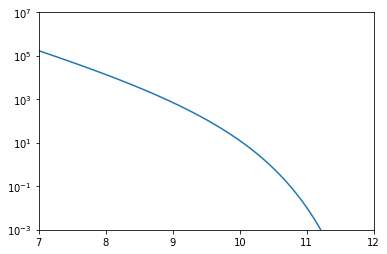

In [604]:
import hmf
from astropy.cosmology import Planck18_arXiv_v2

mf = hmf.MassFunction(hmf_model="Behroozi")
V = 41002
z0 = 4
baryon_frac = 0.16

mf.update(z = z0, Mmin = 3, Mmax = 17, dlog10m = 0.01)
mf.cosmo_model = Planck18_arXiv_v2

dndm = mf.dndlog10m*V
mass = mf.m
sbf = 0.03856609803835385 + 0.017162496006188494 * (z0 - 4) # could possibly include some uncertainty here
stellar_mass = mass * sbf * baryon_frac 

plt.plot(np.log10(stellar_mass), dndm)
plt.yscale("log")
plt.ylim(1e-3, 1e7)
plt.xlim(7, 12)

8.280750000000001

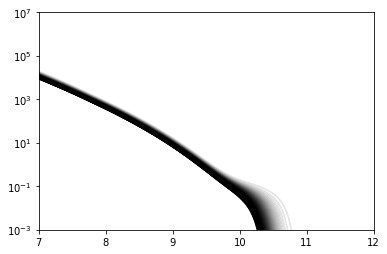

In [605]:
idx = 7
plt.plot(log10m[:-1], smfs[idx], 'k-', alpha = 0.1);
plt.yscale('log')
plt.ylim(1e-3, 1e7)
plt.xlim(7, 12)
z[idx]


We can then compute the confidence intervals from this PDF with `compute_conf_ints` and plot:

In [606]:
def compute_conf_intervals(pdf, x, lims = [0.0013498980, 0.0227501319, 0.15865525, 
                                      0.500, 0.8413447, 0.97724986, 0.998650102]):
    """
    Compute confidence intervals for a given pdf
    
    Parameters
    ----------
    x (array): x coordinates
    pdf (array): probability density function evaluated at x
    lims (array): confidence intervals to compute

    Returns
    -------
    CI (array): confidence intervals
    
    """
    

    norm = integrate.trapz(pdf, x)
    intcum = integrate.cumtrapz(pdf/norm.reshape(-1,1), x, initial=0.)
    print(intcum.shape)
    if np.squeeze(pdf).ndim > 1:
        CI = []
        for ic in intcum:
            CIz = []
            for lim in lims:
                CIz.append(x[np.argmin(np.abs(ic-lim))])
            CI.append(CIz)
    else:
        CI = x[[np.max(np.where(intcum < lim)) for lim in lims]]
        
    return intcum, np.vstack(CI)



(11, 1100)


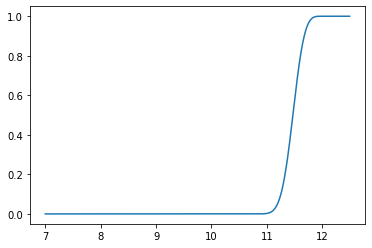

In [607]:
cdfs, CI_mhalo = compute_conf_intervals(phi_max_conv, log10m[:-1])
plt.plot(log10m[:-1], cdfs[0])


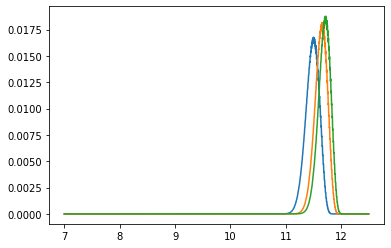

In [608]:
plt.plot(log10m[:-1], phi_maxs[0][:, [-10, -2, -1]])

(213.0, 263.0)

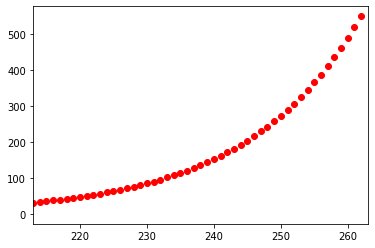

In [609]:
plt.plot(evs_OD, 'ro')
plt.xlim(len(evs_OD)-50, len(evs_OD))

(11, 1100)


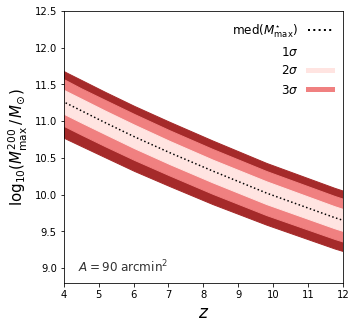

In [610]:
cdf, CI_mhalo = compute_conf_intervals(phi_max_conv, log10m[:-1])

colors = ['brown','lightcoral','mistyrose']

fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.fill_between(z, CI_mhalo[:,0], CI_mhalo[:,6], alpha=1, color=colors[0])
ax.fill_between(z, CI_mhalo[:,1], CI_mhalo[:,5], alpha=1, color=colors[1])
ax.fill_between(z, CI_mhalo[:,2], CI_mhalo[:,4], alpha=1, color=colors[2])
ax.plot(z, CI_mhalo[:,3], linestyle='dotted', c='black')

ax.set_xlim(np.min(z), np.max(z))
ax.set_xlim(4, 12)
ax.set_ylim(8.8, 12.5)

ax.set_xlabel('$z$', size=17)
ax.set_ylabel('$\mathrm{log_{10}}(M^{200}_{\mathrm{max}} \,/\, M_{\odot})$', size=15)
ax.text(0.05, 0.04, '$A = 90 \; \mathrm{arcmin}^2$', size=12, color='black', alpha=0.8, transform = ax.transAxes)

line1 = plt.Line2D((0,1),(0,0), color=colors[0], linewidth=5)
line2 = plt.Line2D((0,1),(0,0), color=colors[1], linewidth=5)
line3 = plt.Line2D((0,1),(0,0), color=colors[2], linewidth=5)
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=2)
line_dummy = plt.Line2D((0,1),(0,0), color='white')
leg = ax.legend(handles=[line4,line_dummy,line3,line2,line1], 
           labels=['$\mathrm{med}(M^{\star}_{\mathrm{max}})$',
               '$1\sigma$', '$2\sigma$', '$3\sigma$'],
                frameon=False, loc='upper right', fontsize=12, ncol=1)

vp = leg._legend_box._children[-1]._children[0] 
for c in vp._children: c._children.reverse() 
vp.align="right" 

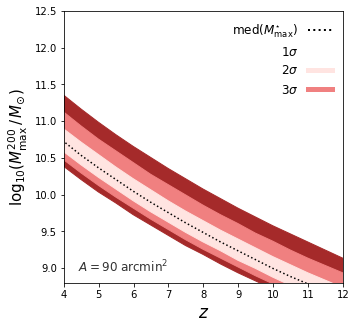

In [611]:
from evstats.stats import compute_conf_ints
from evstats.evs import _apply_fsky

with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf: #'~/Princeton/G2/QuickPaperCharles/evstats/example/data/full_z05.h5'
# with h5py.File(os.path.expanduser('~/Princeton/G2/MostMassive/evstats/example/data/carnall.h5'),'r') as hf: #'~/Princeton/G2/QuickPaperCharles/evstats/example/data/full_z05.h5'
# with h5py.File(os.path.expanduser('~/Princeton/G2/MostMassive/evstats/example/data/new_cosmo.h5'),'r') as hf:

    log10m = hf['log10m'][:]+np.log10(0.16)+np.log10(0.6)+np.log10(0.07)
    f = hf['f'][:]
    F = hf['F'][:]
    N = hf['N'][:]
    z = hf['z'][:]

whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
survey_area = 160 * u.arcmin**2
fsky = float(survey_area / whole_sky)
phi_max0 = _apply_fsky(N, f, F, fsky)

CI_mhalo = compute_conf_ints(phi_max0, log10m)

colors = ['brown','lightcoral','mistyrose']

fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.fill_between(z, CI_mhalo[:,0], CI_mhalo[:,6], alpha=1, color=colors[0])
ax.fill_between(z, CI_mhalo[:,1], CI_mhalo[:,5], alpha=1, color=colors[1])
ax.fill_between(z, CI_mhalo[:,2], CI_mhalo[:,4], alpha=1, color=colors[2])
ax.plot(z, CI_mhalo[:,3], linestyle='dotted', c='black')

ax.set_xlim(np.min(z), np.max(z))
ax.set_xlim(4, 12)
ax.set_ylim(8.8, 12.5)

ax.set_xlabel('$z$', size=17)
ax.set_ylabel('$\mathrm{log_{10}}(M^{200}_{\mathrm{max}} \,/\, M_{\odot})$', size=15)
ax.text(0.05, 0.04, '$A = 90 \; \mathrm{arcmin}^2$', size=12, color='black', alpha=0.8, transform = ax.transAxes)

line1 = plt.Line2D((0,1),(0,0), color=colors[0], linewidth=5)
line2 = plt.Line2D((0,1),(0,0), color=colors[1], linewidth=5)
line3 = plt.Line2D((0,1),(0,0), color=colors[2], linewidth=5)
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=2)
line_dummy = plt.Line2D((0,1),(0,0), color='white')
leg = ax.legend(handles=[line4,line_dummy,line3,line2,line1], 
           labels=['$\mathrm{med}(M^{\star}_{\mathrm{max}})$',
               '$1\sigma$', '$2\sigma$', '$3\sigma$'],
                frameon=False, loc='upper right', fontsize=12, ncol=1)

vp = leg._legend_box._children[-1]._children[0] 
for c in vp._children: c._children.reverse() 
vp.align="right" 

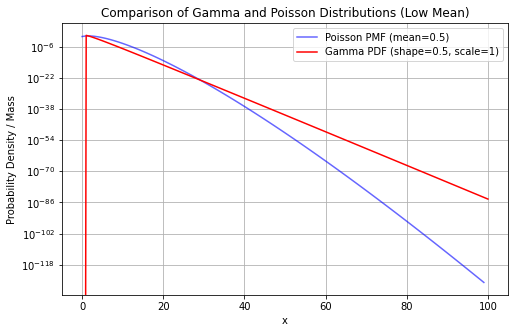

In [612]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define a very low mean
mean = 2  # Low expected value

# Generate Poisson distribution
x_poisson = np.arange(0, 100)
poisson_pmf = stats.poisson.pmf(x_poisson, mean)

# Generate Gamma distribution (Gamma is a continuous distribution, so we discretize it)
shape = mean  # Equivalent to mean for low values
scale = 0.5  # Standard scale parameter
x_gamma = np.linspace(0, 100, 100)
gamma_pdf = stats.gamma.pdf(x_gamma, a=shape, scale=scale)

# Plot distributions
plt.figure(figsize=(8, 5))
plt.plot(x_poisson, poisson_pmf, alpha=0.6, color='b', label='Poisson PMF (mean=0.5)')
plt.plot(x_gamma, gamma_pdf, 'r-', label='Gamma PDF (shape=0.5, scale=1)')

# Labels and legend
plt.xlabel('x')
plt.ylabel('Probability Density / Mass')
plt.yscale('log')
plt.title('Comparison of Gamma and Poisson Distributions (Low Mean)')
plt.legend()
plt.grid()
plt.show()

In [333]:
norm.ppf(0.5)

0.0